This code is designed to run on Google Colab, running on T4 GPU is recommended.

**FULL INSTRUCTION TO RUN THIS CODE**:
- Upload file cropped_faces_2.zip, pretrained_resnet50.pth.
- Please wait for the files to finish uploading before running the next cells.
- In step 1, please uncomment the last line if you want to do again the pretraining part, we import the pretrained_resnet50.pth instead because it takes long time to perform the pretraining.
- The data preprocessing would be really long because we use mtcnn to detect the bounding box and the structure of the face, therefore, the cropped_faces_2.zip is necessary.
- Please check the directory link to these 2 files, and please change so that it is appropriate to your testing environment.
- If you just want to test, you can skip the training cell and change the directory of the "best_model.pth" and "test_image.jpg".

In [ ]:
# Install necessary packages
!pip install torch torchvision gdown tqdm facenet-pytorch

# Import required libraries
import os
import tarfile
from PIL import Image, ImageDraw
import pandas as pd
import torch
import torch.nn as nn
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, KFold
import numpy as np
from tqdm import tqdm
from sklearn.utils import shuffle
from facenet_pytorch import MTCNN
import cv2
from matplotlib import pyplot as plt


# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

INFO: pip is looking at multiple versions of facenet-pytorch to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 36.0 MB/s eta 0:00:00


In [ ]:
# Step 1: Pre-Training on External Dataset (IMDB-WIKI)
def download_and_prepare_external_dataset():
    imdb_wiki_url = "https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki/static/imdb_crop.tar"
    external_dataset_path = "imdb_wiki/"

    if not os.path.exists(external_dataset_path):
        !wget {imdb_wiki_url} -O imdb_crop.tar
        os.makedirs(external_dataset_path, exist_ok=True)
        with tarfile.open("imdb_crop.tar", "r") as tar:
            tar.extractall(path=external_dataset_path)
    return external_dataset_path

def preprocess_external_dataset(data_folder):
    image_files = []
    labels = []
    for root, dirs, files in os.walk(data_folder):
        # Extract the age from the folder name
        folder_name = os.path.basename(root)
        try:
            age = int(folder_name)  # Folder name is the age
            if 0 <= age <= 100:  # Filter valid ages
                for file in files:
                    if file.endswith(".jpg"):
                        image_files.append(os.path.join(root, file))
                        labels.append(age)
        except ValueError:
            # Skip folders that are not age directories
            continue
    return image_files, labels


def train_on_external_dataset():
    # Download and preprocess
    external_dataset_path = download_and_prepare_external_dataset()
    image_files, labels = preprocess_external_dataset(external_dataset_path)

    # Sample a subset of the data (200,000 images for reduced computational cost)
    image_files, labels = shuffle(image_files, labels, random_state=42)
    image_files = image_files[:200000]  # Limit to 200,000 images
    labels = labels[:200000]

    # Transformations
    transform = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomResizedCrop(256, scale=(0.8, 1.0)),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    # Dataset and DataLoader
    class ExternalDataset(Dataset):
        def __init__(self, image_files, labels, transform=None):
            self.image_files = image_files
            self.labels = labels
            self.transform = transform

        def __len__(self):
            return len(self.image_files)

        def __getitem__(self, idx):
            image = Image.open(self.image_files[idx]).convert("RGB")
            label = self.labels[idx]
            if self.transform:
                image = self.transform(image)
            return image, label

    dataset = ExternalDataset(image_files, labels, transform=transform)
    dataloader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=2)

    # Model
    model = models.resnet50(pretrained=True)
    model.fc = nn.Linear(model.fc.in_features, 1)  # Predict age
    model = model.to(device)
    for name, param in model.named_parameters():
        print(f"{name} - requires_grad: {param.requires_grad}")

    # Loss and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)

    # Training loop
    model.train()
    imdb_epoch = 2
    for epoch in range(imdb_epoch):  # Train for 2 epochs
        epoch_loss = 0
        for images, ages in tqdm(dataloader, desc=f"Epoch {epoch + 1}/{imdb_epoch}"):
            images, ages = images.to(device), ages.to(device, dtype=torch.float32).unsqueeze(1)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, ages)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        print(f"Epoch {epoch + 1}, Loss: {epoch_loss / len(dataloader):.4f}")
    # Save pre-trained model
    torch.save(model.state_dict(), f"pretrained_resnet50.pth")

# Uncomment the line below to pre-train on IMDB-WIKI
# train_on_external_dataset()

In [ ]:
import os

# Define the file name and the directory to extract
zip_file = '/content/cropped_faces_2.zip'  # Replace with the name of your zip file
extract_dir = 'Preprocessed_Images'  # Directory where files will be extracted

# Create the directory if it doesn't exist
os.makedirs(extract_dir, exist_ok=True)

# Extract the ZIP file
!unzip -o {zip_file} -d {extract_dir}


Streaming output truncated to the last 5000 lines.
  inflating: Preprocessed_Images/cropped_faces_2/26_1_0_20170117003136628_face_6232.jpg  
  inflating: Preprocessed_Images/cropped_faces_2/34_1_3_20170119163642029_face_2259.jpg  
  inflating: Preprocessed_Images/cropped_faces_2/29_0_1_20170114034635292_face_6460.jpg  
  inflating: Preprocessed_Images/cropped_faces_2/19_1_0_20170103175624137_face_22634.jpg  
  inflating: Preprocessed_Images/cropped_faces_2/47_0_0_20170117155944017_face_11559.jpg  
  inflating: Preprocessed_Images/cropped_faces_2/6_1_0_20170117201301199_face_11366.jpg  
  inflating: Preprocessed_Images/cropped_faces_2/40_1_0_20170104204319051_face_20513.jpg  
  inflating: Preprocessed_Images/cropped_faces_2/1_1_2_20161219220631367_face_20194.jpg  
  inflating: Preprocessed_Images/cropped_faces_2/29_0_4_20170103235032708_face_16921.jpg  
  inflating: Preprocessed_Images/cropped_faces_2/12_0_0_20170117145849076_face_4960.jpg  
  inflating: Preprocessed_Images/cropped_face

In [ ]:
# Step 2: Load UTKFace Dataset
preprocessed_dir = "/content/Preprocessed_Images/cropped_faces_2"
if not(os.path.exists(preprocessed_dir)):
    # The preprocessed_dir does not already exist
    # Dataset URL
    dataset_url = "https://drive.google.com/drive/folders/1HROmgviy4jUUUaCdvvrQ8PcqtNg2jn3G"
    data_folder = "UTKFace/"

    # Download the dataset using gdown
    if not os.path.exists(data_folder):
        !gdown --folder {dataset_url} -O {data_folder}

    # Extract .tar.gz files
    compressed_files_path = os.path.join(data_folder, "UTKface_inthewild/")
    extracted_folder = "UTKFace_extracted/"
    os.makedirs(extracted_folder, exist_ok=True)

    for file_name in os.listdir(compressed_files_path):
        if file_name.endswith(".tar.gz"):
            file_path = os.path.join(compressed_files_path, file_name)
            with tarfile.open(file_path, "r:gz") as tar:
                tar.extractall(path=extracted_folder)

    # Metadata extraction
    def extract_metadata(filename):
        try:
            age, _, _, _ = filename.split('_')
            return int(age)
        except ValueError:
            return None

    # Collect metadata
    image_files = []
    metadata = []

    for root, _, files in os.walk(extracted_folder):
        for file in files:
            if file.endswith(".jpg"):
                image_files.append(os.path.join(root, file))
                metadata.append(extract_metadata(file))

    # Load MTCNN model for image preprocessing
    mtcnn = MTCNN(keep_all=True)

    def align_face(image, landmarks):
        if landmarks is None or len(landmarks) < 1 or len(landmarks[0]) < 2:
            return image,1
        # Extract landmarks for eyes
        left_eye = landmarks[0][0]  # Left eye (x, y)
        right_eye = landmarks[0][1]  # Right eye (x, y)

        # Compute the angle to align the eyes horizontally
        dx, dy = right_eye[0] - left_eye[0], right_eye[1] - left_eye[1]
        angle = np.degrees(np.arctan2(dy, dx))

        # Compute center between the eyes
        eyes_center = ((left_eye[0] + right_eye[0]) / 2, (left_eye[1] + right_eye[1]) / 2)

        # Compute affine transform for rotation
        rotation_matrix = cv2.getRotationMatrix2D(eyes_center, angle, scale=1)

        # Apply rotation to align face
        aligned_image = cv2.warpAffine(
            np.array(image),
            rotation_matrix,
            (image.size[0], image.size[1]),
            flags=cv2.INTER_CUBIC
        )
        return aligned_image,0

    def crop_align(image, use_mtcnn):
        boxes, _, landmarks = use_mtcnn.detect(image, landmarks=True)
        if landmarks is not None:
            image, check = align_face(image, landmarks)
            if check == 0:
                image = Image.fromarray(image)
        if boxes is not None and len(boxes) != 0:
            box = boxes[0]
            box = [int(coord) for coord in box]
            image = image.crop((box[0], box[1], box[2], box[3]))
        else:
            return None
        return image

    # Ensure the new directory exists
    os.makedirs(preprocessed_dir, exist_ok=True)
    valid_files = []
    valid_metadata = []

    for i, meta in enumerate(metadata):
        if meta[0] is not None:  # Ensure metadata is valid
            img = Image.open(image_files[i]).convert("RGB")
            cropped_img = crop_align(img, mtcnn)  # Crop and align using MTCNN
            if cropped_img is not None:  # Ensure cropping was successful
                new_image_path = os.path.join(preprocessed_dir, os.path.basename(image_files[i]))
                cropped_img.save(new_image_path)  # Save the image with the same name but in the new directory
                valid_files.append(image_files[i])
                valid_metadata.append(meta)
            else:
                print(f"Image index [{i}] is not valid.")
else:
    # The preprocessed_dir already exists
    # Metadata extraction
    def extract_metadata(filename):
        try:
            age, _, _, _, _, _ = filename.split('_')
            return int(age)
        except ValueError:
            return None

    # Collect metadata
    image_files = []
    metadata = []
    preprocessed_filenames = os.listdir(preprocessed_dir)
    print(preprocessed_filenames[:10])  # Print first 10 filenames
    for root, _, files in os.walk(preprocessed_dir):
        for file in files:
            if file.endswith(".jpg"):
                image_files.append(os.path.join(root, file))
                metadata.append(extract_metadata(file))
    valid_files = image_files
    valid_metadata = metadata



# Update the original lists with valid entries
image_files = valid_files
metadata = valid_metadata
print(image_files)
print(metadata)

# Check result
print("Total valid images:", len(image_files))

Output hidden; open in https://colab.research.google.com to view.

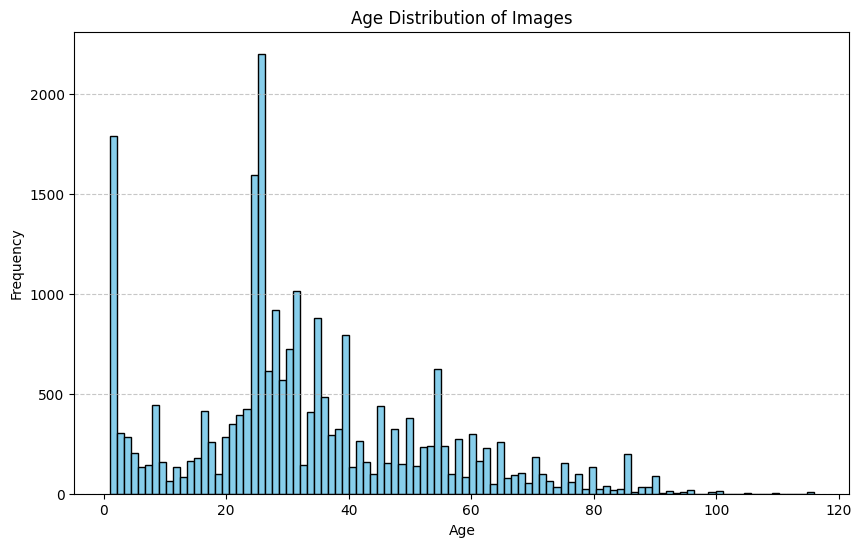

In [ ]:
import matplotlib.pyplot as plt

# Assuming meta_data contains ages as a list or numpy array
# Example: meta_data = [23, 25, 40, 21, 36, ...]

def plot_age_histogram(metadata, bins=10):
    """
    Plots a histogram of ages.

    Args:
        meta_data (list or array): List/array of ages.
        bins (int): Number of bins for the histogram.
    """
    plt.figure(figsize=(10, 6))
    plt.hist(metadata, bins=bins, color='skyblue', edgecolor='black')
    plt.title("Age Distribution of Images")
    plt.xlabel("Age")
    plt.ylabel("Frequency")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

# Example usage
plot_age_histogram(metadata, bins=100)

In [ ]:
# Transformations
transform_train = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomResizedCrop(256, scale=(0.8,1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_test = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
import os
import random
from collections import Counter
from torchvision import transforms
from PIL import Image

random.seed(42)
# Target directory for augmented images
output_dir = "Preprocessed_Images/cropped_faces_2/"
os.makedirs(output_dir, exist_ok=True)

# Step 1: Define Realistic Age Group Ratios
realistic_ratios = {
    (0, 5): 0.08,    # 0–5: 8%
    (6, 10): 0.08,   # 6–10: 8%
    (11, 15): 0.10,  # 11–15: 10%
    (16, 20): 0.10,  # 16–20: 10%
    (21, 25): 0.095, # 21–25: 9.5%
    (26, 30): 0.095, # 26–30: 9.5%
    (31, 35): 0.07,  # 31–35: 7%
    (36, 40): 0.07,  # 36–40: 7%
    (41, 45): 0.06,  # 41–45: 6%
    (46, 50): 0.06,  # 46–50: 6%
    (51, 55): 0.05,  # 51–55: 5%
    (56, 60): 0.05,  # 56–60: 5%
    (61, 65): 0.03,  # 61–65: 3%
    (66, 70): 0.03,  # 66–70: 3%
    (71, 80): 0.015, # 71–80: 1.5%
    (81, 150): 0.015 # 81+: 1.5%
}


# Step 2: Group Ages into Bins
def group_ages(metadata, age_groups):
    grouped = {age_range: [] for age_range in age_groups}
    for idx, age in enumerate(metadata):
        for age_range in age_groups:
            if age_range[0] <= age and age <= age_range[1]:
                grouped[age_range].append(idx)
                break
    return grouped

age_groups = list(realistic_ratios.keys())
grouped_indices = group_ages(metadata, age_groups)

# Step 3: Calculate Target Counts for Each Group1
total_images = len(metadata)
target_counts = {age_range: int(realistic_ratios[age_range] * total_images) for age_range in age_groups}

print("Target Image Counts per Group:")
print(target_counts)

# Step 4: Augmentation Transformations
transform_augment = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomResizedCrop(size=(256, 256), scale=(0.9, 1.0)),
    transforms.Resize((256, 256)),
])

# Step 5: Augment Data and Update Metadata
augmented_count = 0
for age_range, indices in grouped_indices.items():
    current_count = len(indices)
    target_count = target_counts[age_range]

    if current_count < target_count:  # Only augment if underrepresented
        num_to_add = target_count - current_count
        print(f"Augmenting {age_range}: {num_to_add} images needed")

        # Get image paths for this group
        image_paths = [image_files[i] for i in indices]

        # Augment images
        for i in range(num_to_add):
            random_image_path = random.choice(image_paths)
            image = Image.open(random_image_path).convert("RGB")

            # Apply augmentation
            augmented_image = transform_augment(image)

            # Save augmented image
            base_name = os.path.basename(random_image_path).split('.')[0]
            new_image_name = f"{base_name}_aug_{i}.jpg"
            save_path = os.path.join(output_dir, new_image_name)
            augmented_image.save(save_path)

            # Update lists
            image_files.append(save_path)
            metadata.append(random_image_path.split("/")[-1].split("_")[0])  # Add corresponding age

            augmented_count += 1

print(f"Augmented {augmented_count} images to match realistic age distribution.")
print(f"All augmented images saved to: {output_dir}")

# Final Distribution Check
from collections import Counter
final_distribution = Counter(metadata)
print("Final Age Distribution After Augmentation:")
print(final_distribution)


Target Image Counts per Group:
{(0, 5): 1924, (6, 10): 1924, (11, 15): 2405, (16, 20): 2405, (21, 25): 2284, (26, 30): 2284, (31, 35): 1683, (36, 40): 1683, (41, 45): 1443, (46, 50): 1443, (51, 55): 1202, (56, 60): 1202, (61, 65): 721, (66, 70): 721, (71, 80): 360, (81, 150): 360}
Augmenting (6, 10): 1046 images needed
Augmenting (11, 15): 1784 images needed
Augmenting (16, 20): 1349 images needed
Augmenting (41, 45): 348 images needed
Augmenting (46, 50): 435 images needed
Augmenting (56, 60): 212 images needed
Augmenting (61, 65): 18 images needed
Augmenting (66, 70): 243 images needed
Augmented 5435 images to match realistic age distribution.
All augmented images saved to: Preprocessed_Images/cropped_faces_2/
Final Age Distribution After Augmentation:
Counter({26: 2203, 1: 1261, 28: 921, 35: 879, 24: 861, 25: 735, 30: 725, 32: 665, 27: 616, 29: 570, 2: 529, 40: 526, '15': 510, 36: 483, '14': 480, 45: 440, 23: 426, 34: 410, 22: 396, '12': 387, 50: 381, '20': 362, 54: 355, 31: 352, 21

In [ ]:
def plot_age_histogram(metadata, bins=10):
    """
    Plots a histogram of ages.

    Args:
        meta_data (list or array): List/array of ages.
        bins (int): Number of bins for the histogram.
    """
    plt.figure(figsize=(10, 6))
    plt.hist(metadata, bins=bins, color='skyblue', edgecolor='black')
    plt.title("Age Distribution of Images")
    plt.xlabel("Age")
    plt.ylabel("Frequency")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()
metadata = [int (meta) for meta in metadata]
plot_age_histogram(metadata, bins=100)
#######
print(image_files)


# Check the results
print("Total valid images:", len(image_files))

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# Divide the images into age groups to perform stratified sampling
age_groups = [min(meta // 20, 4) for meta in metadata]  # Age groups: 0-20, 21-40, 41-60, 61-80, >80

# Divide the data into train/val/test
train_files, temp_files, train_metadata, temp_metadata = train_test_split(
    image_files, metadata, test_size=0.4, stratify=age_groups, random_state=42
)

# Continue to divide into val and test
val_files, test_files, val_metadata, test_metadata = train_test_split(
    temp_files, temp_metadata, test_size=0.5, random_state=42
)

print(f"Train: {len(train_files)}, Val: {len(val_files)}, Test: {len(test_files)}")

Train: 17692, Val: 5897, Test: 5898


In [ ]:
from typing_extensions import Annotated
# Dataset class
class UTKFaceDataset(Dataset):
    def __init__(self, image_files, metadata, transform=None):
        self.image_files = image_files
        self.metadata = metadata
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_path = self.image_files[idx]
        age = self.metadata[idx]
        image = Image.open(image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, age

In [ ]:
# Create datasets and dataloaders
train_dataset = UTKFaceDataset(train_files, train_metadata, transform=transform_train)
val_dataset = UTKFaceDataset(val_files, val_metadata, transform=transform_test)
test_dataset = UTKFaceDataset(test_files, test_metadata, transform=transform_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=0, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=0, pin_memory=True)

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models

import torch
import torch.nn as nn
import torchvision.models as models

class MultiTaskModel(nn.Module):
    def __init__(self, pretrained=True, imdb_pretrained_path=None, freeze_until='backbone.layer2.0.conv1'):
        super(MultiTaskModel, self).__init__()

        # Backbone
        self.backbone = models.resnet50(pretrained=pretrained)
        num_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Identity()

        # Fully connected layer for age prediction
        self.shared_fc = nn.Sequential(
            nn.Linear(num_features, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.4),  # Updated Dropout
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU()
        )

        # Final prediction for age
        self.age_head = nn.Sequential(
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

        # Custom weight initialization
        for m in self.age_head.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)

        if imdb_pretrained_path:
            state_dict = torch.load(imdb_pretrained_path)
            self.load_partial_state_dict(state_dict)

        self.freeze_layers(freeze_until)

    def freeze_layers(self, freeze_until):
        freeze = True
        for name, param in self.backbone.named_parameters():
            if freeze:
                param.requires_grad = False
            if freeze_until in name:
                freeze = False

    def load_partial_state_dict(self, state_dict):
        model_state_dict = self.state_dict()
        for name, param in state_dict.items():
            if name in model_state_dict and param.size() == model_state_dict[name].size():
                model_state_dict[name] = param
        self.load_state_dict(model_state_dict, strict=False)

    def forward(self, x):
        x = self.backbone(x)
        x = self.shared_fc(x)
        age = self.age_head(x)
        age = torch.clamp(age, 0, 100)  # Clamp age
        return age



In [ ]:
imdb_pretrained_path = "pretrained_resnet50.pth"
model = MultiTaskModel(pretrained=True, imdb_pretrained_path=imdb_pretrained_path, freeze_until='backbone.layer2.0.conv1').to(device)
for name, param in model.named_parameters():
    print(f"{name} - requires_grad: {param.requires_grad}")


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 148MB/s]
<ipython-input-12-e8b70d190b12>:42: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is poss

backbone.conv1.weight - requires_grad: False
backbone.bn1.weight - requires_grad: False
backbone.bn1.bias - requires_grad: False
backbone.layer1.0.conv1.weight - requires_grad: False
backbone.layer1.0.bn1.weight - requires_grad: False
backbone.layer1.0.bn1.bias - requires_grad: False
backbone.layer1.0.conv2.weight - requires_grad: False
backbone.layer1.0.bn2.weight - requires_grad: False
backbone.layer1.0.bn2.bias - requires_grad: False
backbone.layer1.0.conv3.weight - requires_grad: False
backbone.layer1.0.bn3.weight - requires_grad: False
backbone.layer1.0.bn3.bias - requires_grad: False
backbone.layer1.0.downsample.0.weight - requires_grad: False
backbone.layer1.0.downsample.1.weight - requires_grad: False
backbone.layer1.0.downsample.1.bias - requires_grad: False
backbone.layer1.1.conv1.weight - requires_grad: False
backbone.layer1.1.bn1.weight - requires_grad: False
backbone.layer1.1.bn1.bias - requires_grad: False
backbone.layer1.1.conv2.weight - requires_grad: False
backbone.lay

In [ ]:
from tqdm import tqdm

# Optimizer and Scheduler
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
training_epoch = 20

# === Load Checkpoint ===
try:
    checkpoint = torch.load('checkpoint.pth', map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    start_epoch = checkpoint['epoch']
    best_val_loss = checkpoint['best_val_loss']
    print(f"Resuming from checkpoint, starting from epoch {start_epoch} with best_val_loss {best_val_loss:.4f}")
except FileNotFoundError:
    print("No checkpoint found, starting from scratch.")
    start_epoch = 1
    best_val_loss = float('inf')

# Training Loop
for epoch in range(start_epoch, training_epoch + 1):
    print(f"\nEpoch {epoch}/{training_epoch}")

    # === Training ===
    model.train()
    train_loss = 0.0
    with tqdm(train_loader, desc=f"Epoch {epoch} [Training]", leave=True) as train_progress:
        for images, ages in train_progress:
            images, ages = images.to(device), ages.to(device)
            optimizer.zero_grad()
            age_pred = model(images)
            loss = nn.MSELoss()(age_pred, ages.unsqueeze(1).float())
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            train_progress.set_postfix({"Loss": f"{train_loss / len(train_loader):.4f}"})

    train_loss /= len(train_loader)

    # === Validation ===
    model.eval()
    val_loss = 0.0
    with tqdm(val_loader, desc=f"Epoch {epoch} [Validating]", leave=True) as val_progress:
        with torch.no_grad():
            for images, ages in val_progress:
                images, ages = images.to(device), ages.to(device)
                age_pred = model(images)
                loss = nn.MSELoss()(age_pred, ages.unsqueeze(1).float())
                val_loss += loss.item()
                val_progress.set_postfix({"Loss": f"{val_loss / len(val_loader):.4f}"})
    val_loss /= len(val_loader)

    # === Epoch Summary ===
    print(f"Epoch {epoch}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}")

    # === Save Checkpoint ===
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_model.pth")
        print(f"Best model saved at epoch {epoch} with Val Loss: {val_loss:.4f}")

    checkpoint = {
        'epoch': epoch + 1,  # Save the next epoch
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'best_val_loss': best_val_loss
    }
    torch.save(checkpoint, f'checkpoint_after_epoch{epoch}.pth')

    # Update Scheduler
    scheduler.step(val_loss)


<ipython-input-14-da2b0908b6b1>:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('checkpoint.pth', map_location=device)


No checkpoint found, starting from scratch.

Epoch 1/20


Epoch 1 [Validating]: 100%|██████████| 93/93 [00:42<00:00,  2.20it/s, Loss=108.7048]


Epoch 1: Train Loss = 386.0249, Val Loss = 108.7048
Best model saved at epoch 1 with Val Loss: 108.7048

Epoch 2/20


Epoch 2 [Validating]: 100%|██████████| 93/93 [00:42<00:00,  2.19it/s, Loss=81.3436]


Epoch 2: Train Loss = 82.0390, Val Loss = 81.3436
Best model saved at epoch 2 with Val Loss: 81.3436

Epoch 3/20


Epoch 3 [Validating]: 100%|██████████| 93/93 [00:42<00:00,  2.18it/s, Loss=64.8879]


Epoch 3: Train Loss = 71.1940, Val Loss = 64.8879
Best model saved at epoch 3 with Val Loss: 64.8879

Epoch 4/20


Epoch 4 [Validating]: 100%|██████████| 93/93 [00:42<00:00,  2.20it/s, Loss=58.7294]


Epoch 4: Train Loss = 60.8681, Val Loss = 58.7294
Best model saved at epoch 4 with Val Loss: 58.7294

Epoch 5/20


Epoch 5 [Validating]: 100%|██████████| 93/93 [00:42<00:00,  2.20it/s, Loss=56.3079]


Epoch 5: Train Loss = 56.5539, Val Loss = 56.3079
Best model saved at epoch 5 with Val Loss: 56.3079

Epoch 6/20


Epoch 6 [Validating]: 100%|██████████| 93/93 [00:42<00:00,  2.16it/s, Loss=53.7115]


Epoch 6: Train Loss = 52.4557, Val Loss = 53.7115
Best model saved at epoch 6 with Val Loss: 53.7115

Epoch 7/20


Epoch 7 [Validating]: 100%|██████████| 93/93 [00:42<00:00,  2.18it/s, Loss=53.3259]


Epoch 7: Train Loss = 50.1192, Val Loss = 53.3259
Best model saved at epoch 7 with Val Loss: 53.3259

Epoch 8/20


Epoch 8 [Validating]: 100%|██████████| 93/93 [00:42<00:00,  2.17it/s, Loss=50.3485]


Epoch 8: Train Loss = 46.4240, Val Loss = 50.3485
Best model saved at epoch 8 with Val Loss: 50.3485

Epoch 9/20


Epoch 9 [Validating]: 100%|██████████| 93/93 [00:43<00:00,  2.15it/s, Loss=47.7332]


Epoch 9: Train Loss = 43.9261, Val Loss = 47.7332
Best model saved at epoch 9 with Val Loss: 47.7332

Epoch 10/20


Epoch 10 [Validating]: 100%|██████████| 93/93 [00:42<00:00,  2.20it/s, Loss=51.5758]


Epoch 10: Train Loss = 42.1353, Val Loss = 51.5758

Epoch 11/20


Epoch 11 [Validating]: 100%|██████████| 93/93 [00:43<00:00,  2.16it/s, Loss=51.3071]


Epoch 11: Train Loss = 43.6571, Val Loss = 51.3071

Epoch 12/20


Epoch 12 [Validating]: 100%|██████████| 93/93 [00:43<00:00,  2.16it/s, Loss=47.0991]


Epoch 12: Train Loss = 39.8333, Val Loss = 47.0991
Best model saved at epoch 12 with Val Loss: 47.0991

Epoch 13/20


Epoch 13 [Validating]: 100%|██████████| 93/93 [00:42<00:00,  2.20it/s, Loss=45.9992]


Epoch 13: Train Loss = 38.5246, Val Loss = 45.9992
Best model saved at epoch 13 with Val Loss: 45.9992

Epoch 14/20


Epoch 14 [Validating]: 100%|██████████| 93/93 [00:40<00:00,  2.29it/s, Loss=47.3430]


Epoch 14: Train Loss = 35.3216, Val Loss = 47.3430

Epoch 15/20


Epoch 15 [Validating]: 100%|██████████| 93/93 [00:40<00:00,  2.31it/s, Loss=45.5275]


Epoch 15: Train Loss = 32.6509, Val Loss = 45.5275
Best model saved at epoch 15 with Val Loss: 45.5275

Epoch 16/20


Epoch 16 [Validating]: 100%|██████████| 93/93 [00:40<00:00,  2.29it/s, Loss=43.6358]


Epoch 16: Train Loss = 30.9691, Val Loss = 43.6358
Best model saved at epoch 16 with Val Loss: 43.6358

Epoch 17/20


Epoch 17 [Validating]: 100%|██████████| 93/93 [00:40<00:00,  2.30it/s, Loss=43.8207]


Epoch 17: Train Loss = 29.3065, Val Loss = 43.8207

Epoch 18/20


Epoch 18 [Validating]: 100%|██████████| 93/93 [00:40<00:00,  2.30it/s, Loss=41.9797]


Epoch 18: Train Loss = 28.5374, Val Loss = 41.9797
Best model saved at epoch 18 with Val Loss: 41.9797

Epoch 19/20


Epoch 19 [Validating]: 100%|██████████| 93/93 [00:40<00:00,  2.32it/s, Loss=43.7955]


Epoch 19: Train Loss = 28.4911, Val Loss = 43.7955

Epoch 20/20


Epoch 20 [Validating]: 100%|██████████| 93/93 [00:40<00:00,  2.32it/s, Loss=46.5328]


Epoch 20: Train Loss = 26.7693, Val Loss = 46.5328


**EVALUATION**

In [ ]:

import torch
import numpy as np
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error, median_absolute_error, r2_score
)
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
from scipy import stats


def evaluate_model(model, test_loader, device="cuda", save_dir="evaluation_results"):
    """
    Enhanced evaluation function for regression models.
    Saves results, visualizes errors, and computes comprehensive metrics.
    """
    os.makedirs(save_dir, exist_ok=True)  # Create directory to save results

    model.eval()
    all_preds = []
    all_labels = []
    batch_mae = []
    batch_mse = []

    with torch.no_grad():
        for batch_idx, (images, ages) in enumerate(test_loader):
            images, ages = images.to(device), ages.to(device)
            age_pred = model(images)

            # Detach and move to CPU for analysis
            all_preds.append(age_pred.cpu())
            all_labels.append(ages.cpu())

            # Calculate batch-level MAE/MSE
            batch_mae_val = mean_absolute_error(ages.cpu().numpy(), age_pred.cpu().numpy())
            batch_mse_val = mean_squared_error(ages.cpu().numpy(), age_pred.cpu().numpy())
            batch_mae.append(batch_mae_val)
            batch_mse.append(batch_mse_val)

    # Concatenate all batch predictions and labels
    all_preds = torch.cat(all_preds).numpy()
    all_labels = torch.cat(all_labels).numpy()

    # Calculate overall metrics
    mae = mean_absolute_error(all_labels, all_preds)
    mse = mean_squared_error(all_labels, all_preds)
    rmse = np.sqrt(mse)
    medae = median_absolute_error(all_labels, all_preds)
    r2 = r2_score(all_labels, all_preds)

    # Log metrics
    print("\nOverall Metrics:")
    print(f"MAE: {mae:.4f}")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"Median AE: {medae:.4f}")
    print(f"R² Score: {r2:.4f}")

    # Save metrics
    metrics = {
        "MAE": mae,
        "MSE": mse,
        "RMSE": rmse,
        "Median_AE": medae,
        "R2_Score": r2,
    }
    metrics_df = pd.DataFrame([metrics])
    metrics_df.to_csv(os.path.join(save_dir, "evaluation_metrics.csv"), index=False)

    # # Visualize results
    plot_predictions(np.array(all_labels), np.array(all_preds).flatten(), save_dir)
    plot_residuals(np.array(all_labels), np.array(all_preds).flatten(), save_dir)
    plot_qq_plot(np.array(all_labels), np.array(all_preds).flatten(), save_dir)
    plot_metrics(batch_mae, batch_mse, save_dir)

    # Log top errors
    log_top_errors(np.array(all_labels), np.array(all_preds).flatten(), save_dir)

    return {"metrics": metrics, "predictions": all_preds, "labels": all_labels}


def plot_predictions(true_labels, predicted_labels, save_dir):
    """Scatter plot of predicted vs. true labels."""
    plt.figure(figsize=(8, 8))
    plt.scatter(true_labels, predicted_labels, alpha=0.5, color="blue", s=10)
    plt.plot([min(true_labels), max(true_labels)], [min(true_labels), max(true_labels)],
             color="red", linestyle="--", label="Perfect Prediction")
    plt.xlabel("True Age")
    plt.ylabel("Predicted Age")
    plt.title("Predicted Age vs True Age")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.savefig(os.path.join(save_dir, "predictions_vs_actuals.png"))
    plt.close()




def plot_residuals(true_labels, predicted_labels, save_dir):
    """Residual plot to check for error patterns."""
    print(true_labels)
    print(predicted_labels)
    residuals = predicted_labels - true_labels
    plt.figure(figsize=(8, 6))
    plt.scatter(true_labels, residuals, alpha=0.5, color="green")
    plt.axhline(y=0, color="red", linestyle="--")
    plt.xlabel("True Values")
    plt.ylabel("Residuals")
    plt.title("Residuals vs True Values")
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.savefig(os.path.join(save_dir, "residuals_plot.png"))
    plt.close()


def plot_qq_plot(true_labels, predicted_labels, save_dir):
    """QQ Plot to visualize normality of residuals."""
    errors = predicted_labels - true_labels
    plt.figure(figsize=(8, 6))
    stats.probplot(errors, dist="norm", plot=plt)
    plt.title("QQ Plot of Prediction Errors")
    plt.savefig(os.path.join(save_dir, "qq_plot.png"))
    plt.close()


def plot_metrics(mae_values, mse_values, save_dir):
    """Plot batch-wise MAE and MSE."""
    plt.figure(figsize=(8, 6))
    plt.plot(mae_values, label="Batch MAE", color="blue")
    plt.plot(mse_values, label="Batch MSE", color="red")
    plt.xlabel("Batch Index")
    plt.ylabel("Error")
    plt.title("MAE and MSE over Batches")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.savefig(os.path.join(save_dir, "metrics_over_batches.png"))
    plt.close()


def log_top_errors(true_labels, predicted_labels, save_dir, top_n=10):
    """Log the top N largest errors."""
    errors = np.abs(predicted_labels - true_labels)
    top_errors = np.argsort(-errors)[:top_n]

    print("\nTop Errors:")
    for idx in top_errors:
        print(f"True: {true_labels[idx]}, Predicted: {predicted_labels[idx]}, Error: {errors[idx]:.4f}")

    # Save to file
    top_errors_df = pd.DataFrame({
        "True_Value": true_labels[top_errors],
        "Predicted_Value": predicted_labels[top_errors],
        "Error": errors[top_errors],
    })
    top_errors_df.to_csv(os.path.join(save_dir, "top_errors.csv"), index=False)


model.load_state_dict(torch.load('/content/best_model.pth'))
# Assuming your model is trained and test_loader is set
results = evaluate_model(model, test_loader, device='cuda')

<ipython-input-19-9abdbed16403>:158: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/best_model.pth'))



Overall Metrics:
MAE: 4.5110
MSE: 42.3380
RMSE: 6.5068
Median AE: 3.1087
R² Score: 0.8924
[12 50 30 ... 11  8 20]
[23.947937 48.38542  33.82902  ... 13.326223  8.72641  25.021442]

Top Errors:
True: 2, Predicted: 61.81944274902344, Error: 59.8194
True: 4, Predicted: 49.13700866699219, Error: 45.1370
True: 3, Predicted: 47.13745880126953, Error: 44.1375
True: 50, Predicted: 87.10629272460938, Error: 37.1063
True: 36, Predicted: 72.85836791992188, Error: 36.8584
True: 12, Predicted: 48.302398681640625, Error: 36.3024
True: 53, Predicted: 17.095436096191406, Error: 35.9046
True: 26, Predicted: 60.639888763427734, Error: 34.6399
True: 10, Predicted: 44.15840530395508, Error: 34.1584
True: 26, Predicted: 59.44050216674805, Error: 33.4405


<ipython-input-12-e8b70d190b12>:42: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(imdb_pretrained_path)
<ipython-input-22-c36daa5807c4>:58: FutureWar

Predicted Age: 16.67 years


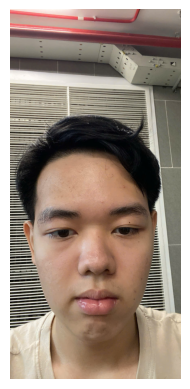

In [ ]:
# Function to preprocess a single image
def preprocess_image(image_path, transform):
    image = Image.open(image_path).convert("RGB")
    mtcnn = MTCNN(keep_all=True)

    # Crop and align the face
    def align_face(image, landmarks):
        if landmarks is None or len(landmarks) < 1 or len(landmarks[0]) < 2:
            return image, 1
        # Extract landmarks for eyes
        left_eye = landmarks[0][0]  # Left eye (x, y)
        right_eye = landmarks[0][1]  # Right eye (x, y)

        # Compute the angle to align the eyes horizontally
        dx, dy = right_eye[0] - left_eye[0], right_eye[1] - left_eye[1]
        angle = np.degrees(np.arctan2(dy, dx))

        # Compute center between the eyes
        eyes_center = ((left_eye[0] + right_eye[0]) / 2, (left_eye[1] + right_eye[1]) / 2)

        # Compute affine transform for rotation
        rotation_matrix = cv2.getRotationMatrix2D(eyes_center, angle, scale=1)

        # Apply rotation to align face
        aligned_image = cv2.warpAffine(
            np.array(image),
            rotation_matrix,
            (image.size[0], image.size[1]),
            flags=cv2.INTER_CUBIC
        )
        return aligned_image, 0

    def crop_align(image, mtcnn):
        boxes, _, landmarks = mtcnn.detect(image, landmarks=True)
        if landmarks is not None:
            image, check = align_face(image, landmarks)
            if check == 0:
                image = Image.fromarray(image)
        if boxes is not None and len(boxes) != 0:
            box = boxes[0]
            box = [int(coord) for coord in box]
            image = image.crop((box[0], box[1], box[2], box[3]))
        else:
            return None
        return image

    cropped_img = crop_align(image, mtcnn)
    if cropped_img is None:
        raise ValueError("No face detected in the image.")

    # Apply the transformation
    return transform(cropped_img).unsqueeze(0)  # Add batch dimension

# # Load the trained model
imdb_pretrained_path = "pretrained_resnet50.pth"

model = MultiTaskModel(pretrained=True, imdb_pretrained_path=imdb_pretrained_path, freeze_until='layer2').to(device)
model.load_state_dict(torch.load("/content/best_model.pth", map_location=device))
model.eval()

# Function to predict age for a single image
def predict_age(image_path):
    try:
        # Preprocess the image
        transformed_image = preprocess_image(image_path, transform_test).to(device)

        # Predict
        with torch.no_grad():
            age_pred = model(transformed_image)
            predicted_age = age_pred.item()  # Extract the scalar value
        print(f"Predicted Age: {predicted_age:.2f} years")
    except Exception as e:
        print(f"Error during prediction: {e}")


# Test the new model with an image
test_image_path = "/content/test_image.jpg"  # Replace with the path to your test image
predict_age(test_image_path)
img = Image.open("test_image.jpg")
plt.imshow(img)
plt.axis('off')
plt.show()